<a href="https://colab.research.google.com/github/JaradAng/tensorflow_training/blob/main/transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
Using the Keras Functional API (a differnt way to build models in Keras)
Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
Data augmentation (how to make your training dataset more diverse without adding more data)
Running a series of modelling experiments on our Food Vision data
Model 0: a transfer learning model using the Keras Functional API
Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
Model 3: a fine-tuned transfer learning model on 10% of the data
Model 4: a fine-tuned transfer learning model on 100% of the data
Introduce the ModelCheckpoint callback to save intermediate training results
Compare model experiments results using TensorBoard

In [72]:
#bringing in the helper functions to save time
!wget https://raw.githubusercontent.com/JaradAng/tensorflow_training/main/helper_functions.py

--2022-12-14 20:48:21--  https://raw.githubusercontent.com/JaradAng/tensorflow_training/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10234 (10.0K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]   9.99K  --.-KB/s    in 0s      

2022-12-14 20:48:21 (94.7 MB/s) - ‘helper_functions.py.1’ saved [10234/10234]



In [73]:
#importing them to notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [74]:
#bringing in the data and this time seeing how to use pretrained models within tf.keras.applications
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2022-12-14 20:48:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  23.9MB/s    in 7.8s    

2022-12-14 20:48:30 (20.6 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [75]:
#checking out num of images and subdirs
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [76]:
# creating the test and train paths
train_dir = '/content/10_food_classes_10_percent/train'

test_dir = '/content/10_food_classes_10_percent/test'

In [77]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size= BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                           image_size = IMG_SIZE,
                                                                           label_mode = 'categorical',
                                                                           batch_size = BATCH_SIZE)                         

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [78]:
#checking type of train
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [79]:
#checking out class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [80]:
#see an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images,labels)


tf.Tensor(
[[[[8.04846954e+01 5.74846954e+01 3.94846954e+01]
   [7.60510178e+01 5.30510178e+01 3.50510178e+01]
   [7.60816345e+01 5.30816345e+01 3.50816345e+01]
   ...
   [8.85714035e+01 7.35714035e+01 6.65714035e+01]
   [8.87857285e+01 7.57857285e+01 6.97857285e+01]
   [8.79999313e+01 7.49999313e+01 6.89999313e+01]]

  [[7.90000000e+01 5.60000000e+01 4.06632652e+01]
   [7.90000000e+01 5.60000000e+01 4.01326523e+01]
   [8.01275558e+01 5.71275520e+01 4.15255089e+01]
   ...
   [9.08316269e+01 7.39438782e+01 6.69438782e+01]
   [9.07193604e+01 7.57193604e+01 7.07193604e+01]
   [8.91888123e+01 7.41888123e+01 6.91888123e+01]]

  [[7.93571396e+01 5.57857132e+01 4.40000000e+01]
   [7.72704086e+01 5.36989784e+01 4.19132652e+01]
   [7.81224518e+01 5.45510216e+01 4.27653084e+01]
   ...
   [9.40000229e+01 7.45714493e+01 6.87857361e+01]
   [9.77142334e+01 7.87703629e+01 7.47703629e+01]
   [9.73675003e+01 7.91532135e+01 7.51532135e+01]]

  ...

  [[4.37704315e+01 3.47704315e+01 2.57704315e+01]
   [4

Model 0: Building a transfer learning model using the Keras Functional API
Alright, our data is tensor-ified, let's build a model.

To do so we're going to be using the tf.keras.applications module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

Instantiate a pre-trained base model object by choosing a target model such as EfficientNetB0 from tf.keras.applications, setting the include_top parameter to False (we do this because we're going to create our own top, which are the output layers for the model).
Set the base model's trainable attribute to False to freeze all of the weights in the pre-trained model.
Define an input layer for our model, for example, what shape of data should our model expect?
[Optional] Normalize the inputs to our model if it requires. Some computer vision models such as ResNetV250 require their inputs to be between 0 & 1.
🤔 Note: As of writing, the EfficientNet models in the tf.keras.applications module do not require images to be normalized (pixel values between 0 and 1) on input, where as many of the other models do. I posted an issue to the TensorFlow GitHub about this and they confirmed this.

Pass the inputs to the base model.
Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using tf.keras.layers.GlobalAveragePooling2D() or tf.keras.layers.GlobalMaxPooling2D() though the former is more common in practice.
Create an output activation layer using tf.keras.layers.Dense() with the appropriate activation function and number of neurons.
Combine the inputs and outputs layer into a model using tf.keras.Model().
Compile the model using the appropriate loss function and choose of optimizer.
Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).
Woah... that sounds like a lot. Before we get ahead of ourselves, let's see it in practice.

In [81]:
 #writing a functional api model and transfer learning
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

 #. Freeze base
base_model.trainable = False

 #Create the inputs
inputs = tf.keras.layers.Input(shape=(224,224,3), name = 'input_layer')

 #4. If using model like resnet50v2 - will need to normalize input not for efficient net
# x = tf.keras.experimental.preprocessing.Rescaling(1./255)(inputs)

 #5. pass the inputs to the base model
x=base_model(inputs)
print(f'shape after passing through basemodel {x.shape}')

 #6. Average pool of outputs of the base model to reduce computations
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'the shape after global pooling is: {x.shape}')


#7. Create output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name = 'output_layer')(x)

#8. combine input and output into a model
model_0 = tf.keras.Model(inputs, outputs)



shape after passing through basemodel (None, 7, 7, 1280)
the shape after global pooling is: (None, 1280)


In [82]:
#compile the model
model_0.compile(loss = 'categorical_crossentropy',
                optimizer ='Adam',
                metrics=['accuracy'])



In [83]:
#fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs = 5,
                        steps_per_epoch= len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks = [create_tensorboard_callback("transfer_learning",
                                                                '10_percent_feature_extraction')])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20221214-204837
Epoch 1/5
24/24 [==============================] - 15s 383ms/step - loss: 1.8309 - accuracy: 0.4280 - val_loss: 1.2534 - val_accuracy: 0.7472
Epoch 2/5
24/24 [==============================] - 8s 325ms/step - loss: 1.0784 - accuracy: 0.7627 - val_loss: 0.8472 - val_accuracy: 0.8220
Epoch 3/5
24/24 [==============================] - 8s 328ms/step - loss: 0.7912 - accuracy: 0.8253 - val_loss: 0.6860 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 8s 326ms/step - loss: 0.6467 - accuracy: 0.8533 - val_loss: 0.6002 - val_accuracy: 0.8584
Epoch 5/5
24/24 [==============================] - 8s 321ms/step - loss: 0.5509 - accuracy: 0.8720 - val_loss: 0.5493 - val_accuracy: 0.8624


In [13]:
#evaulate
model_0.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.5586 - accuracy: 0.8600


[0.5586393475532532, 0.8600000143051147]

In [84]:
#check the layers in base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_14
1 rescaling_13
2 normalization_13
3 tf.math.truediv_13
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expan

In [15]:
#summary 
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
#summary of whole modle
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


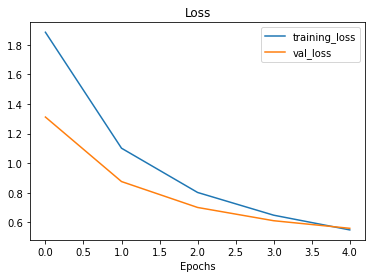

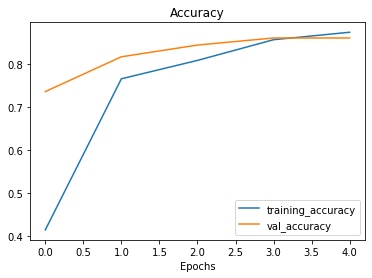

In [17]:
#plot the loss curve
plot_loss_curves(history_0)

### getting a feature vector from a trained model

demonstrat the global pooling 2d layer

base model shape of (none, 7,7,1280)

but after passing through Globalavereagepooling2d is turns into (none, 1280) transforms 4d tensor into 2d tensor

In [85]:
#demonstrating the affects
input_shape = (1,4,4,3)

# Create random tensor
tf.random.set_seed(42)

input_tensor = tf.random.normal(input_shape)

print(f'Random input tensor: {input_tensor}')

#pass random tensor through global avg pooling 2d layer
global_avg_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f'global avg tensor: {global_avg_pooled_tensor}\n')

Random input tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
global avg tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]



### Running a series of transfer learning experiments

going to test the functional api on 1% of training data

1. model_1 will use feature extraction with 1% of training data with data augmentation
2. model_2 use feature extraction with 10% of training with data augmentation
3. model_3 use fine tuning on 10% of train data with data augmentation
4. model_4 use fine tuning with 100% of training data wwith augmentation

In [19]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2022-12-14 18:33:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  22.3MB/s    in 7.8s    

2022-12-14 18:33:53 (16.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
unzip_data('10_food_classes_1_percent.zip')

In [21]:
#walk thru dir
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [59]:
#getting test and train 

train_dir_1_percent = '/content/10_food_classes_1_percent/train'

test_data = '/content/10_food_classes_1_percent/test'

In [87]:
#how many images

train_data_one = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=(224,224))

test_data_one = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(224,224))
     

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [86]:
#building a data augmentation layer into the models layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [88]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  # preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

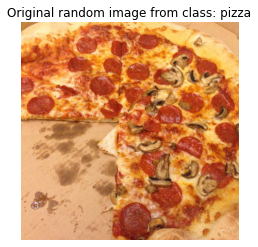

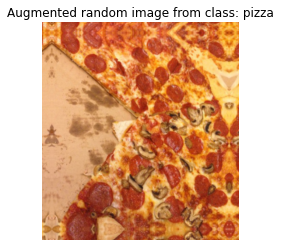

In [89]:
 #viz and test the data augmentation layer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_one.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path

# Plot the random image (original)
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

#building the model_1 using 1 percent of training data

In [90]:

# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_one,
                    epochs=5,
                    steps_per_epoch=len(train_data_one),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])
     

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20221214-205014
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.4427 - accuracy: 0.1000

3/3 [==============================] - 10s 2s/step - loss: 2.4427 - accuracy: 0.1000 - val_loss: 2.2293 - val_accuracy: 0.1793
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1335 - accuracy: 0.3429 - val_loss: 2.0880 - val_accuracy: 0.2747
Epoch 3/5
3/3 [==============================] - 3s 2s/step - loss: 1.9254 - accuracy: 0.4143 - val_loss: 1.9742 - val_accuracy: 0.3569
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7715 - accuracy: 0.5286 - val_loss: 1.8658 - val_accuracy: 0.4326
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6082 - accuracy: 0.6286 - val_loss: 1.7898 - val_accuracy: 0.4836


Cant figure out the tuple error

### Model_2 10% again with data aug

In [91]:
# creating the test and train paths
train_dir = '/content/10_food_classes_10_percent/train'

test_dir = '/content/10_food_classes_10_percent/test'

Already walked through and explored the 10% data
Already done the preprocessing in above cells 

In [94]:
#building a new data augmentation layer

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    #preprocessing.Rescale(1./255)
], name = 'data_augmentation')

#set up input shape
input_shape = (224, 224, 3)

#create frozen base model also called backbone
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#create inputs and outputs
inputs = layers.Input(shape = input_shape,name = 'input_layer')

x = data_augmentation(inputs) #augment the training data

x = base_model(x, training = False)#pass augmented imaged to base mode but keep base model in inference mode not updating weights, ensures batch norm layers dont get updated

x = layers.GlobalAveragePooling2D(name = 'global_avg_pooling_2D')(x)

outputs = layers.Dense(10, activation = 'softmax', name = 'out_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)


#compile the model
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy'])

#create model checkpoint
checkpoint_path = 'ten_percent_model_checkpoint_weights/checkpoint.ckpt'

#create modelcheckpoint callback to save the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = 'epoch', #saves every epoch,
                                                         verbose=1)





In [95]:
#fit
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data= test_data,
                        validation_steps = len(test_data),
                        callbacks = [create_tensorboard_callback('transfer_learning', 'model_2_10_with_aug'),
                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/model_2_10_with_aug/20221214-211417
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9660 - accuracy: 0.3773
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 20s 587ms/step - loss: 1.9660 - accuracy: 0.3773 - val_loss: 1.4248 - val_accuracy: 0.6784
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3039 - accuracy: 0.7040
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 13s 521ms/step - loss: 1.3039 - accuracy: 0.7040 - val_loss: 0.9856 - val_accuracy: 0.7832
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9982 - accuracy: 0.7653
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 12s 498ms/step - loss: 0.9982 - accuracy: 0.7653 - val_loss: 0.7969 - val_accuracy: 0.8108
Epoc

In [96]:
#Model 0 results
model_0.evaluate(test_data)

79/79 [==============================] - 7s 74ms/step - loss: 0.5493 - accuracy: 0.8624


[0.5492798686027527, 0.8623999953269958]

In [98]:
results_10_percent_data = model_2.evaluate(test_data)
results_1_percent_data = model_1.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 1.7775 - accuracy: 0.4952


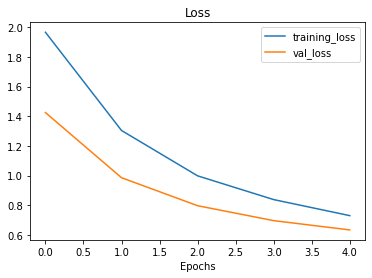

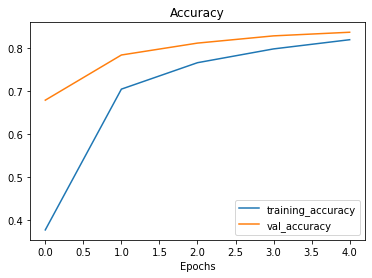

In [99]:
#plot the loss curves
plot_loss_curves(history_2)

In [100]:
#load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [101]:
#eval on model 2 with checkpoint weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.6337 - accuracy: 0.8360


In [102]:
#if the results match the loaded weights, everything has works
import numpy as np
np.isclose(np.array(results_10_percent_data), np.array(loaded_weights_model_results))

array([ True,  True])

In [103]:
#check difference
print(np.array(results_10_percent_data)- np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]
